This notebook compares the cross section of HITEMP2019 CO with petitRadtran

author: Hajime Kawahara

last update: August 11th (2021)

In [1]:
from exojax.spec import make_numatrix0
from exojax.spec.lpf import xsvector
from exojax.spec.lpf import auto_xsection
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import moldb
import numpy as np
import tqdm
import jax.numpy as jnp
from jax import vmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [2]:
from scipy.constants import Boltzmann, proton_mass, speed_of_light, m_u, Planck
k1=np.float32(Planck*speed_of_light/Boltzmann*1.e2)
k2=np.float32(np.sqrt(Boltzmann/m_u)/speed_of_light) # if T is given
k3=np.float32(1.e-2/speed_of_light/(4.0*np.pi))
print(k1,k2,k3)

1.4387769 3.04156e-07 2.6544188e-12


In [3]:
import pandas as pd
#Kawashima
dat=pd.read_csv("~/exojax/data/CO/05-1.0E-03bar_1.0E+00.dat",delimiter=",")
#Helios K
datH=pd.read_csv("~/HELIOS-K/Out_i.dat",delimiter="\s",names=("wn","val"))


~/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [4]:
w=np.array(dat["wav"])*1.e4 #angstrom
wcm=np.array(dat["wav"])*1.e-4 #cm
#subtract Rayleigh scattering
aRay=1.95e-24
absco=dat["absco"]-128.0/3.0*np.pi**5*aRay**2/(wcm**4)

nusH=datH["wn"]
wH=1.e8/nusH #angstrom
absH=datH["val"]

In [5]:
import numpy as np
import astropy.units as u
wls = w[::-1] #
nus = 100000000/wls #cm-1

In [6]:
mdbCO=moldb.MdbHit('~/exojax/data/CO/05_hit12.par',nus)

In [7]:
#USE TIPS partition function
Q296=np.array([107.25937215917970,224.38496958496091,112.61710362499998,\
     660.22969049609367,236.14433662109374,1382.8672147421873])
Q1000=np.array([382.19096582031250,802.30952197265628,402.80326733398437,\
2357.1041210937501,847.84866308593757,4928.7215078125000])
qr=Q1000/Q296

In [8]:
qt=np.ones_like(mdbCO.isoid,dtype=np.float64)
for idx,iso in enumerate(mdbCO.uniqiso):
    mask=mdbCO.isoid==iso
    qt[mask]=qr[idx]

In [9]:
Mmol=28.010446441149536
Tref=296.0
Tfix=1000.0
Pfix=1.e-3 #bar

Sij=SijT(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)
gammaL = gamma_hitran(Pfix,Tfix,Pfix, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self)
#+ gamma_natural(A) #uncomment if you inclide a natural width
sigmaD=doppler_sigma(mdbCO.nu_lines,Tfix,Mmol)

In [10]:
#check memory size. If the size is large, decrease d.
d=10000
ll=mdbCO.nu_lines+mdbCO.delta_air*Pfix
numatrix=make_numatrix0(nus[0:d],ll)
print("memory size=",numatrix.nbytes/1024/1024,"MB")

memory size= 175.7049560546875 MB


In [11]:
Ni=int(len(nus)/d)
xsv=[]
for i in tqdm.tqdm(range(0,Ni+1)):
    s=int(i*d);e=int((i+1)*d);e=min(e,len(nus))
    numatrix=make_numatrix0(nus[s:e],ll)
    xsv = np.concatenate([xsv,xsvector(numatrix,sigmaD,gammaL,Sij)])

100%|█████████████████████████████████████████| 331/331 [00:44<00:00,  7.51it/s]


In [13]:
#or just use xsection
xsv=auto_xsection(nus,ll,sigmaD,gammaL,Sij,memory_size=30)

100%|███████████████████████████████████████| 1939/1939 [00:52<00:00, 37.13it/s]


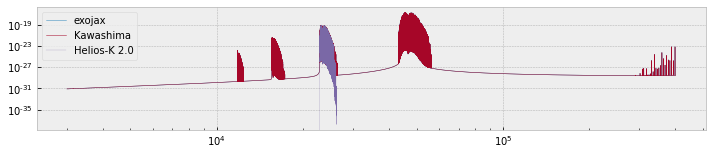

In [14]:
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(211)
plt.plot(wls,xsv,lw=0.5,label="exojax")
#plt.plot(wls_modit,xs_modit,lw=0.5,label="exojax")
plt.plot(w,absco,lw=0.5,label="Kawashima")
plt.plot(wH,absH,label="Helios-K 2.0",lw=0.2)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="upper left")
#plt.xlim(40000,50000)
plt.savefig("co_hitran.png")
plt.show()

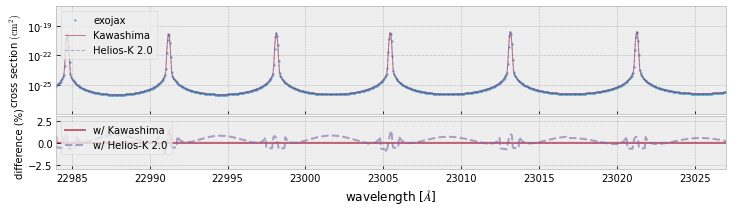

In [15]:
llow=2300.4
lhigh=2300.7

ii=np.searchsorted(w,wH[0])
iie=ii-len(wH)
wH=np.array(wH)
absHc=absH[::-1]

xsvc=xsv[::-1]

fig=plt.figure(figsize=(12,3))
#ax=fig.add_subplot(211)
ax=plt.subplot2grid((12, 1), (0, 0),rowspan=8)
plt.plot(wls,xsv,".",label="exojax",color="C0",markersize=3,alpha=0.5)
plt.plot(w,absco,lw=1.0,label="Kawashima",color="C1",alpha=0.5)
plt.plot(wH,absH,lw=1.0,label="Helios-K 2.0",color="C2",ls="dashed",alpha=0.5)
plt.ylim(1.1e-28,1.e-17)
plt.yscale("log")
tip=20.0
plt.xlim(llow*10.0-tip,lhigh*10.0+tip)
plt.legend(loc="upper left")
plt.ylabel("cross section $(\mathrm{cm}^{2})$",fontsize=10)
plt.xticks(color="None")
#ax=fig.add_subplot(212)
ax=plt.subplot2grid((12, 1), (8, 0),rowspan=4)
plt.plot(w,(xsvc-absco)/absco,alpha=0.6,color="C1",\
          label="w/ Kawashima")
plt.plot(w[iie:ii],(xsvc[iie+1:ii+1]-absHc)/absHc*100,color="C2",alpha=0.6,\
         ls="dashed",label="w/ Helios-K 2.0")
plt.ylabel("difference (%)",fontsize=10)
#for iline in wline:
#    plt.axvline(iline,lw=0.3)
plt.xlim(llow*10.0-tip,lhigh*10.0+tip)
plt.ylim(-3,3)
plt.xlabel('wavelength [$\AA$]')
#plt.legend()
plt.legend(loc="upper left")
plt.savefig("comparison.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

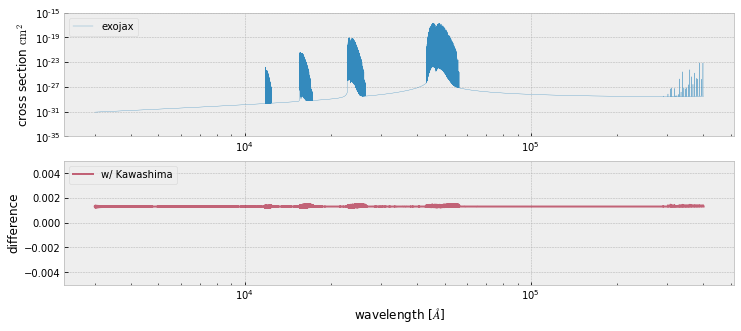

In [16]:
xsvc=xsv[::-1]
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(211)
plt.plot(wls,xsv,lw=0.3,label="exojax",color="C0", rasterized=True)
#plt.plot(w,absco,lw=0.5,label="Kawashima",color="C1")
#plt.plot(wH,absH,label="Helios-K 2.0",color="C2")
plt.ylim(1.e-35,1.e-15)
#plt.xlim(50000.0,50300.0)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="upper left")
plt.ylabel("cross section $\mathrm{cm}^{2}$")
ax=fig.add_subplot(212)
plt.plot(w,(xsvc-absco)/absco,alpha=0.6,color="C1",\
          label="w/ Kawashima", rasterized=True)
#plt.plot(w[iie:ii],(absHc-xsvc[iie+1:ii+1])/absHc,color="C2",alpha=0.6,\
#         ls="dashed",label="w/ Helios K-2.0")
plt.ylabel("difference")
#for iline in wline:
#    plt.axvline(iline,lw=0.3)
#plt.xlim(50000.0,50300.0)
plt.ylim(-0.005,0.005)
plt.xlabel('wavelength [$\AA$]')
#plt.legend()
plt.xscale("log")
plt.legend(loc="upper left")
plt.savefig("comparison_wide.pdf", bbox_inches="tight", pad_inches=0.0, dpi=400)
plt.show()

In [17]:
#Checking mass center +- 0.1 cm-1
wline=100000000/mdbCO.nu_lines
xsvc=xsv[::-1]
lw=len(w)
wid=10
xe=[]#center for exojax
xk=[]#center for kawashima
wca=[]
for wc in tqdm.tqdm(wline):
    i=np.searchsorted(w,wc)
    iq=i+wid
    ip=i-wid
    if iq<lw and ip>-1:
        xc_e=np.sum((1.e8/w[ip:iq])*xsvc[ip:iq])/np.sum(xsvc[ip:iq])
        xc_k=np.sum((1.e8/w[ip:iq])*absco[ip:iq])/np.sum(absco[ip:iq])
        xe.append((xc_e-1.e8/wc))
        xk.append((xc_k-1.e8/wc))
        wca.append(wc)
xe=np.array(xe)
xk=np.array(xk)
wca=np.array(wca)

100%|█████████████████████████████████████| 4606/4606 [00:01<00:00, 3802.67it/s]


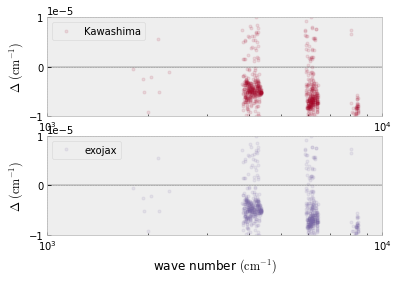

In [18]:
#+- 0.1 cm-1
fig=plt.figure()
ax=fig.add_subplot(211)
plt.plot(1.e8/wca,xk,".",alpha=0.1,color="C1",label="Kawashima")
plt.ylim(-0.00001,0.00001)
plt.xlim(1.e3,1.e4)
#plt.xlim(1.e4,3.e4)
plt.axhline(0.0,color="black",lw=0.3)
plt.ylabel("$\Delta \, \, (\mathrm{cm^{-1}})$")
plt.axhline(0.0002,lw=0.5)
plt.xscale("log")
plt.legend(loc="upper left")
ax=fig.add_subplot(212)
plt.plot(1.e8/wca,xe,".",alpha=0.1,color="C2",label="exojax")
#plt.plot(wca,xk,".")
plt.xscale("log")
plt.ylim(-0.00001,0.00001)
plt.xlim(1.e3,1.e4)
plt.axhline(0.0,color="black",lw=0.3)
plt.ylabel("$\Delta \, \, (\mathrm{cm^{-1}})$")
plt.axhline(0.0002,lw=0.5)
plt.legend(loc="upper left")
plt.xlabel("wave number $(\mathrm{cm}^{-1})$")
plt.savefig("center.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

Don't worry. This trend is just due to pressure shift